# Fit a Gaussian Process

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def pretty_name(text, sep=","):
    text = text.replace(sep, ",\n")
    return text

## 1. Fitting GPs over a sinusoidal function

In [3]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

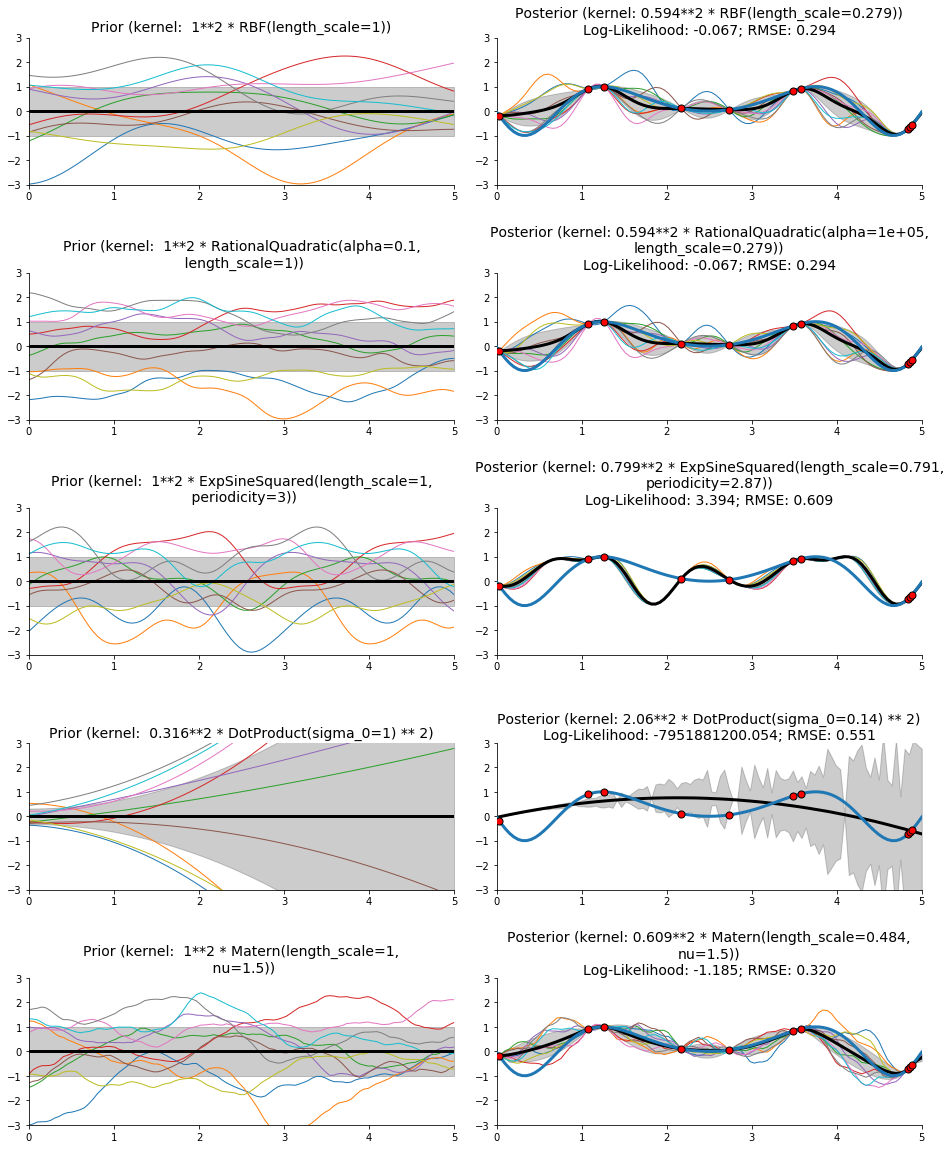

In [4]:
fig, axs = plt.subplots(5, 2, figsize=(16,20))
plt.subplots_adjust(hspace=0.6, wspace=0.1)
i=0
for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior

    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    axs[i,0].plot(X_, y_mean, 'k', lw=3, zorder=9)
    axs[i,0].fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    axs[i,0].plot(X_, y_samples, lw=1)
    axs[i,0].set_xlim(0, 5)
    axs[i,0].set_ylim(-3, 3)
    axs[i,0].set_title(pretty_name("Prior (kernel:  %s)" % kernel), fontsize=14)
    axs[i,0].spines['right'].set_visible(False)
    axs[i,0].spines['top'].set_visible(False)
    
    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    axs[i,1].plot(X_, y_mean, 'k', lw=3, zorder=9, label="Posterior Mean")
    axs[i,1].fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    axs[i,1].plot(X_, y_samples, lw=1)
    axs[i,1].scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    axs[i,1].set_xlim(0, 5)
    axs[i,1].set_ylim(-3, 3)
    axs[i,1].spines['right'].set_visible(False)
    axs[i,1].spines['top'].set_visible(False)
    
    # Ground truth
    X = np.linspace(0,5, 100)
    y = np.sin((X - 2.5) ** 2)
    RMSE = ((y_mean-y)**2).mean()**0.5
    axs[i,1].plot(X,y, label="Ground Truth", lw=3, zorder=9)
    axs[i,1].set_title(pretty_name("Posterior (kernel: %s)\n Log-Likelihood: %.3f; RMSE: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta), RMSE)),
              fontsize=14, wrap=True)
    i+=1

fig.savefig("img/gp1.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

**Figure 1**: Prior and posterior of a Gaussian Process Regression with different kernels. Mean (black line), standard deviation (grey area), 10 samples (red points) and ground truth (blue line) are shown.

In this exercise we fit a Gaussian Process (GP) with different kernels to a sinusoidal function (see Figure 1). Based on fit on training set, the GP with the best performance, i.e., with higher likelihood, is the GP with Exponential Sine Squared (ESS) kernel, this has a log-likelihood of 3.394. However, GPs with kernels Radial Basic Funtion (RBF), Rational Quadratic (RQ) and Mattern kernel better capture smooth pattern of sinusoidal function. This can be seen by comparing the Root Mean Square Error (RMSE) in the intervale [0,5], where the RMSE of ESS is about twice the RMSE than the other kernels mentioned. Note that the RMSE is calculated by evaluating the sinusoidal function and the posterior mean on an equispaced sample of size 100 in the interval [0,5].

Luego se construye una muestra de 20 puntos provenientes de un GP con kernel RQ y se define un nuevo kernel llamado monster_kernel compuesto de la suma de todos los kernels anteriormente utilizados a la lista.

# 2. Fitting GPs over a sample generated by a GP


In [5]:
# data
np.random.seed(0)
X = np.random.uniform(0,5,20)[:, np.newaxis]

kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
gp = GaussianProcessRegressor(kernel=kernel)
y = np.ravel(gp.sample_y(X))

# mosnter kernel
monster_kernel = (0.2 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + 
                  0.2 * RationalQuadratic(length_scale=1.0, alpha=0.1) +
                  0.2 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)) +
                  ConstantKernel(0.2, (0.01, 10.0)) * (DotProduct(sigma_0=0.1, sigma_0_bounds=(0.1, 10.0)) ** 2) + 
                  0.2 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5) )

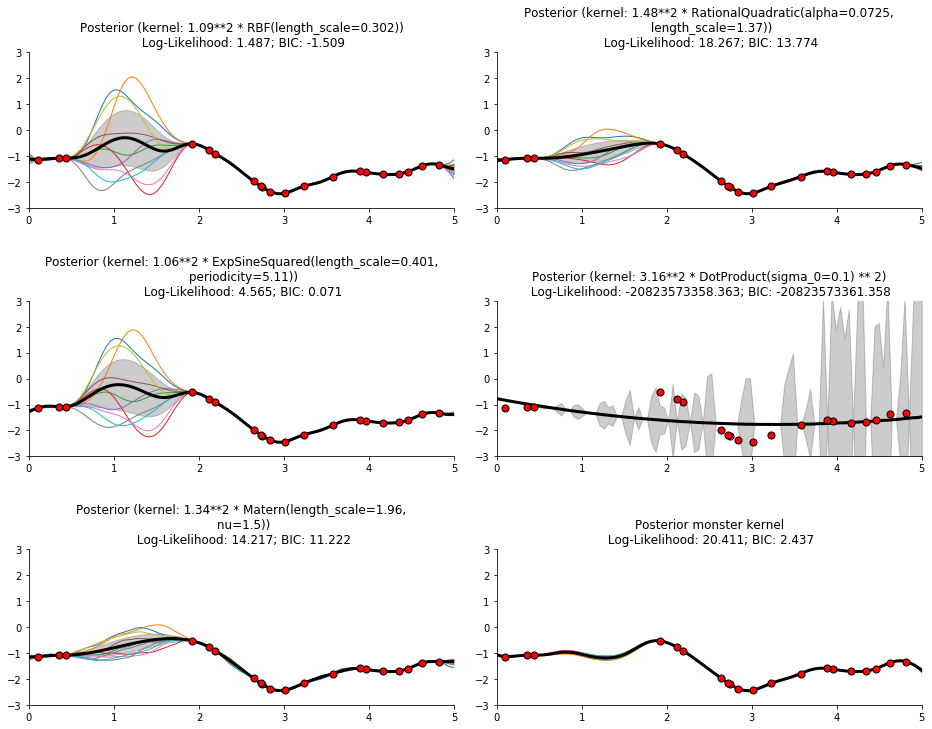

Monster kernel parameters:
0.669**2 * RBF(length_scale=1.37) + 0.00316**2 * RationalQuadratic(alpha=1.33e+03, length_scale=3.12) + 0.591**2 * ExpSineSquared(length_scale=0.837, periodicity=2.93) + 0.1**2 * DotProduct(sigma_0=1.8) ** 2 + 0.00316**2 * Matern(length_scale=0.158, nu=1.5)


In [6]:
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5),
          monster_kernel]
i=0
fig, axs = plt.subplots(3, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.6, wspace=0.1)
for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Fit GP
    gp.fit(X, y)

    # Plot posterior
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    axs[i//2,i%2].plot(X_, y_mean, 'k', lw=3, zorder=9)
    axs[i//2,i%2].fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    axs[i//2,i%2].plot(X_, y_samples, lw=1)
    axs[i//2,i%2].scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    axs[i//2,i%2].set_xlim(0, 5)
    axs[i//2,i%2].set_ylim(-3, 3)
    axs[i//2,i%2].spines['right'].set_visible(False)
    axs[i//2,i%2].spines['top'].set_visible(False)
    
    # Bayesian Information Criteria (BIC)
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    BIC = log_likelihood-gp.kernel.n_dims/2*np.log(20)
    if kernel != monster_kernel:
        axs[i//2,i%2].set_title(pretty_name("Posterior (kernel: %s)\n Log-Likelihood: %.3f; BIC: %.3f"
                  % (gp.kernel_,log_likelihood,BIC)),
                  fontsize=12)
    else:
        axs[i//2,i%2].set_title(pretty_name("Posterior monster kernel\n Log-Likelihood: %.3f; BIC: %.3f"
                  % (log_likelihood, BIC)),
                  fontsize=12)
        

   
    
    i+=1

plt.show()
print("Monster kernel parameters:\n%s" % gp.kernel_)
fig.savefig("img/gp2.pdf",transparent = True, bbox_inches = 'tight', pad_inches = 0)

**Figure 2**: Posterior of a GPR with different kernels. Mean (black line), standard deviation (grey area) and 20 samples from a GP with RQ kernel (red points) are shown.

In this case, we generate 20 samples from a GP with RQ kernel and fit some GPs with different kernels (see Figure 2). Similarly, based on fit on training set, the GP with the best performance is the GP with monster kernel. This is because this kernel has great flexibility compared to the other kernels used. For that reason, this kernel is more likely to overfit data. To solve that problem, we can use a metric that penalize model complexity, such as the Bayesian Information Criteria (BIC), this metric penalizes the log-likelihood by the product between the number of free parameters $d$ (in this case, the parameters to be fitted) and the logarithm of the number of samples, mathematically is 

\begin{align}
    BIC = log p(D|\hat{\theta}_{ML})-\frac{d}{2}log(N)
\end{align}

, based in BIC the best model is the RQ kernel, the same one that generates the training data.

## 3. Simplify kernel complexity

When adjusting multiple kernels, a good heuristic to simplify the model is to start by eliminating those kernels that contribute less in magnitude, that is, the kernels with the lowest scale factor ($ \ sigma ^ {2} $). In this case for the monster kernel we have the follo parameters


```
Monster kernel parameters:
0.669**2 * RBF(length_scale=1.37) + 0.00316**2 * RationalQuadratic(alpha=1.33e+03, length_scale=3.12) + 0.591**2 * ExpSineSquared(length_scale=0.837, periodicity=2.93) + 0.1**2 * DotProduct(sigma_0=1.8) ** 2 + 0.00316**2 * Matern(length_scale=0.158, nu=1.5)
```

, where we can see that scale factor ($\sigma^{2}$) from RQ and Matern are approximately five orders of magnitude lower than when used alone, and four orders less than RBF, ESS and Dot Product (DP).

## 4. Increasing kernel complexity

When kernels are added continuously the log-likelihood tends to increase (due to the increase in the complexity of the model), and by consequence the risk of overfitting too, this situacion is worse when we have small data or the phenomenon does not have high complexity. This problem can be solved evaluating the generalization capacity in validation set (not seen on training time) from differents kernels, using metric like RMSE or Mean Absolute Error (MAE), since it is a regression problem. Alternatively, we can use information theory metrics such as BUC or Akaike Information Criteria (AIC), these measure penalize the log-likelihood by model complexity, in this way, a more complex model requires an increase in performance according to the increase in complexity.

## 5. Setting the init kernel parameter in a GP

In [7]:
# data
np.random.seed(123)
X = np.random.uniform(0,5,10)[:, np.newaxis]
y = np.cos(X[:,0]*2*np.pi)+X[:,0]

In [8]:
# linear regression
X_ = np.hstack((np.ones(len(X))[:,np.newaxis], X))
theta = np.dot(np.linalg.inv(np.dot(X_.T,X_)), np.dot(X_.T, y))
intercept, slope = theta
sigma = (y-intercept+slope*X[:,0]).std()

In [9]:
# kernel
kernel = (sigma**2 * ExpSineSquared(length_scale=1.0, periodicity=1, 
                 length_scale_bounds=(1e-1, 10.0),  periodicity_bounds=(1, 10)) +
          slope**2 * DotProduct(sigma_0=intercept)
)

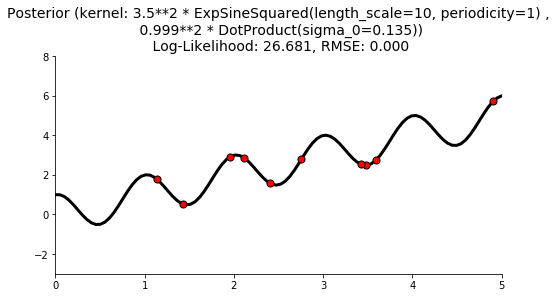

In [10]:
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel)

# Fit GP
gp.fit(X, y)

# Plot posterior
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(X_, y_mean, 'k', lw=3, zorder=9)
ax.fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 10)
ax.plot(X_, y_samples, lw=1)
ax.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
ax.set_xlim(0, 5)
ax.set_ylim(-3, 8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
y_true = np.cos(X_*2*np.pi)+X_
RMSE = (((y_mean-y_true)**2).mean())**0.5
ax.plot(X_, y_true)
ax.set_title(pretty_name("Posterior (kernel: %s)\n Log-Likelihood: %.3f, RMSE: %.3f"
          % (gp.kernel_,log_likelihood,RMSE), sep="+"),
          fontsize=14)
fig.savefig("img/gp3.pdf",transparent = True, bbox_inches = 'tight', pad_inches = 0)

We create a synthetic signal, where the training data $D = \{x_{i},y_{i}\}_{i=1}^{10}$, the $x_{i}$ are i.i.d as a $U(0,5)$ and $y_{i} = x_{i}+cos(2\pi x_{i})$. How the data look non-stationary and periodic we use a DP plus ESS kernel, this is illustrated in equations 2-4. 

\begin{align}
k_{DP}(x,x') &= \sigma_{0}^{2}+x_{i}x_{j}\\
k_{ESS}(x,x') &= exp\bigg(\frac{2sin^{2}(\pi |x-x'|/p)}{l^{2}}\bigg)\\
k(x,x') &= \sigma_{DP}^{2}k_{DP}(x,x')+\sigma_{ESS}^{2}k_{ESS}(x,x')
\end{align}

The objective function of a GP is not convex, this is why it becomes very important to choose the initial parameters correctly to start near a good local optimum. The init parameters for the $k_{DP}$  were chosen using a linear regression. The linear regression was fitted on training data, with $\theta_{0}$ as intercept and $\theta_{1}$ as slope. Then the setting was $\sigma_{DP}^{2}$ equal to the slope and $\sigma_{0}^{2}$ equal to the intercept. The variance with respect to the mean estimated by the linear regression is used as $\sigma_{ESS}^{2}$, i.e., $\sigma_{ESS}^{2}=\frac{\sum_{i=1}^{N}(\theta_{0}+\theta_{1}x_{i}-y_{i})^{2}}{N}$. The periodicity $p$ was setted in 1 with bound between [1,10], this is due that in the interval [0,5] we has 10 samples, so the maximum peridiocity that we can observe is 10 (twice the interval size) and the minimum is 1 (twice the interval size divided by the number of samples). Finally, the $\ell$ parameter controls the smoothness, as this is not much, it was set to a value of 1 with a limit of [0.1,10].